In [21]:
%matplotlib inline
from __future__ import division
import numpy as np
import sys
sys.path.append('../src')

import keras
from keras import backend as K
K.set_image_dim_ordering('th')
from tqdm import tqdm
from glob import glob

import metrics
import custom_layers
import dataset


In [22]:
input_files = glob('../data/ucid/*.tif')
np.random.seed(1)
print len(input_files)
np.random.shuffle(input_files)




1338


In [23]:
from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [24]:
#IN_SIZE = 128

def my_net():
    inputs = Input((1, IN_SIZE, IN_SIZE))
    l = custom_layers.to_dct_layers(inputs)

    conv = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(l)
    conv = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv)
    l = conv
    
    conv = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(l)
    conv = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv)
    l = merge([conv, l], mode='sum', concat_axis=1)
    
    l = custom_layers.to_pixel_layers(l, restore_size=IN_SIZE)
    
    model = Model(input=inputs, output=l)
    model.compile(optimizer=Adam(lr=5e-5), loss='mean_squared_error', metrics=['mean_squared_error', metrics.PSNRLoss])
    
    return model

IN_SIZE = 128

def my_net2():
    inputs = Input((1, IN_SIZE, IN_SIZE))
    
    # DCT branch
    l = custom_layers.to_dct_layers(inputs)

    conv = Convolution2D(64, 3, 3, activation='relu', border_mode='same', init='he_uniform')(l)
    conv = Convolution2D(128, 3, 3, activation='relu', border_mode='same', init='he_uniform', subsample=(2,2))(conv)
    #l = custom_layers.SubSampleLayer(2)(l)
    l = conv
    
    conv = Convolution2D(128, 3, 3, activation='relu', border_mode='same', init='he_uniform')(conv)
    conv = Convolution2D(128, 3, 3, activation='relu', border_mode='same', init='he_uniform')(conv)
    l = merge([conv, l], mode='sum', concat_axis=1)
    
    conv = Convolution2D(128, 3, 3, activation='relu', border_mode='same', init='he_uniform', subsample=(2,2))(l)
    conv = Convolution2D(128, 3, 3, activation='relu', border_mode='same', init='he_uniform', subsample=(2,2))(conv)
    conv = Convolution2D(128, 3, 3, activation=None, border_mode='same', init='he_uniform')(conv)
    
    conv = Convolution2D(64, 1, 1, activation=None, border_mode='same', init='he_uniform')(conv)
    l = conv
    #l = custom_layers.SubSampleLayer(2)(conv)
    
    l = custom_layers.to_pixel_layers(l, R=1, restore_size=IN_SIZE)
    
    # PIXEL branch
    
    conv = Convolution2D(32, 3, 3, activation='relu', border_mode='same', init='he_uniform')(inputs)
    conv = Convolution2D(64, 3, 3, activation='relu', border_mode='same', init='he_uniform')(conv)
    
    p = conv
    
    conv = Convolution2D(64, 3, 3, activation='relu', border_mode='same', init='he_uniform')(p)
    conv = Convolution2D(64, 3, 3, activation='relu', border_mode='same', init='he_uniform')(conv)
    p = merge([conv, p], mode='sum', concat_axis=1)
    
    conv = Convolution2D(64, 3, 3, activation='relu', border_mode='same', init='he_uniform')(p)
    conv = Convolution2D(64, 3, 3, activation='relu', border_mode='same', init='he_uniform')(conv)
    p = merge([conv, p], mode='sum', concat_axis=1)
    
    # Aggregation
    
    #q=p
    q = merge([l, p], mode='concat', concat_axis=1)
    #q = l
    #m = l
    m = Convolution2D(128, 3, 3, activation='relu', border_mode='same', init='he_uniform')(q)
    m = Convolution2D(128, 3, 3, activation='relu', border_mode='same', init='he_uniform')(m)
    m = Convolution2D(1, 1, 1, activation=None, border_mode='same', init='he_uniform')(m)
    
    #m = l
    
    model = Model(input=inputs, output=m)
    model.compile(optimizer=Adam(lr=1e-3), loss='mean_squared_error', metrics=['mean_squared_error', metrics.PSNRLoss])
    
    return model

def SI_module(inputs, dict_size=256):
    D_a = Convolution2D(dict_size, 1, 1, activation=None, border_mode='same', init='he_uniform')(inputs)
    
    D_s = Convolution2D(64, 1, 1, activation=None, border_mode='same', init='he_uniform')(inputs)
    
    
    


In [25]:
residual = False
quality_factor = 20

def psnr_of_im(t):
    im, res = t
    if residual:
        return metrics.psnr(np.zeros_like(res), res)
    else:
        return metrics.psnr(im, res)
    

val_generator, val_samples_per_epoch = dataset.get_image_generator(input_files[1000:], batch_size=32, 
                                                                   residual=residual, quality_factor=quality_factor)
t = [psnr_of_im(next(val_generator)) for _ in tqdm(range(500))]
    

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:43<00:00, 11.40it/s]


In [ ]:
print np.mean(t)
reload(custom_layers) #29.5ish
reload(dataset)

28.068633828


<module 'dataset' from '../src\dataset.pyc'>

In [ ]:
model = my_net2()
model_checkpoint = ModelCheckpoint('myres5.hdf5', monitor='loss', save_best_only=True)

train_generator, train_samples_per_epoch = dataset.get_image_generator(input_files[:1000], crop_size=IN_SIZE, batch_size=24, residual=residual, 
                                                                       quality_factor=quality_factor, deterministic=False)
val_generator, val_samples_per_epoch = dataset.get_image_generator(input_files[1000:], crop_size=IN_SIZE, batch_size=24, residual=residual, 
                                                                   quality_factor=quality_factor, deterministic=True)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                  patience=5, min_lr=0.00000001, verbose=1)


hist = model.fit_generator(train_generator, train_samples_per_epoch*5, 
                    nb_epoch=5000, 
                    verbose=1, 
                    validation_data=val_generator,
                    nb_val_samples=val_samples_per_epoch*5,
callbacks=[model_checkpoint, reduce_lr])

Epoch 1/5000
 264/5000 [>.............................] - ETA: 193s - loss: 72700.0922 - mean_squared_error: 72700.0922 - PSNRLoss: 6.8428

In [19]:
model = my_net2()
#model.load_weights('unet.hdf5')
model.load_weights('myres4.hdf5')
quality_factor = 20
val_generator, val_samples_per_epoch = dataset.get_image_generator(input_files[:1000], 
                                                                   crop_size=128, 
                                                                   batch_size=24, 
                                                                   residual=residual, quality_factor=quality_factor)

batch = next(val_generator)
x_images = batch[0]
y_target = batch[1]


y_pred = model.predict(x_images)

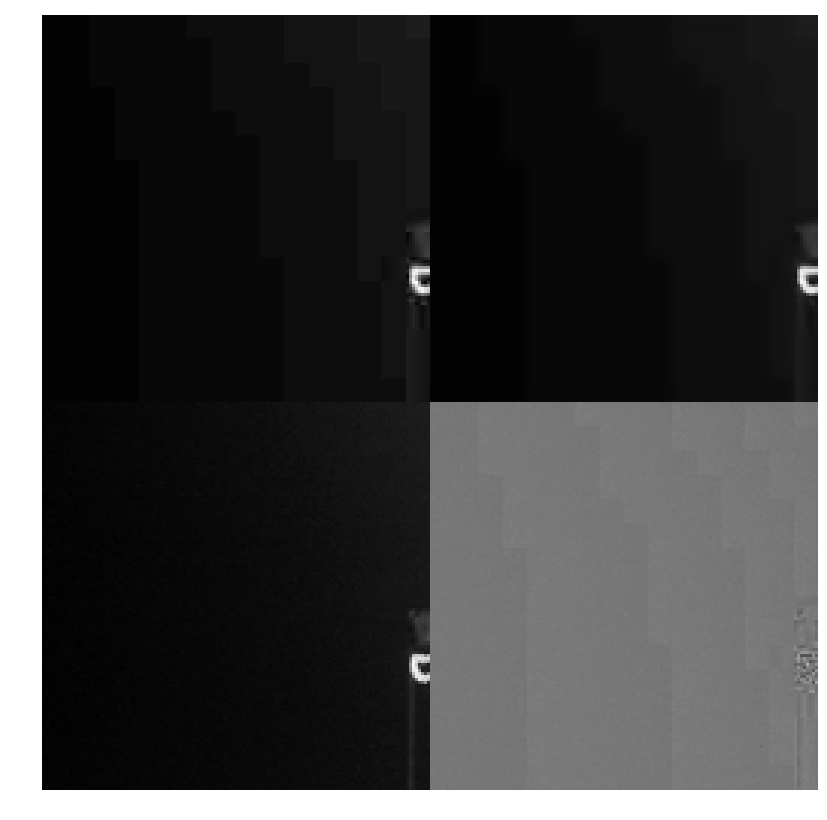

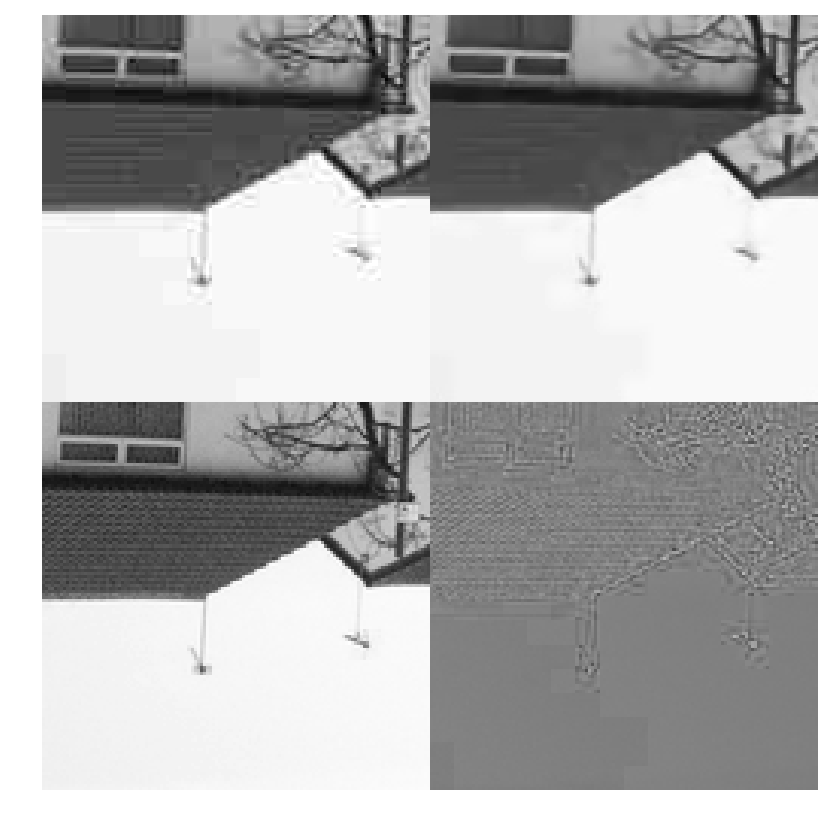

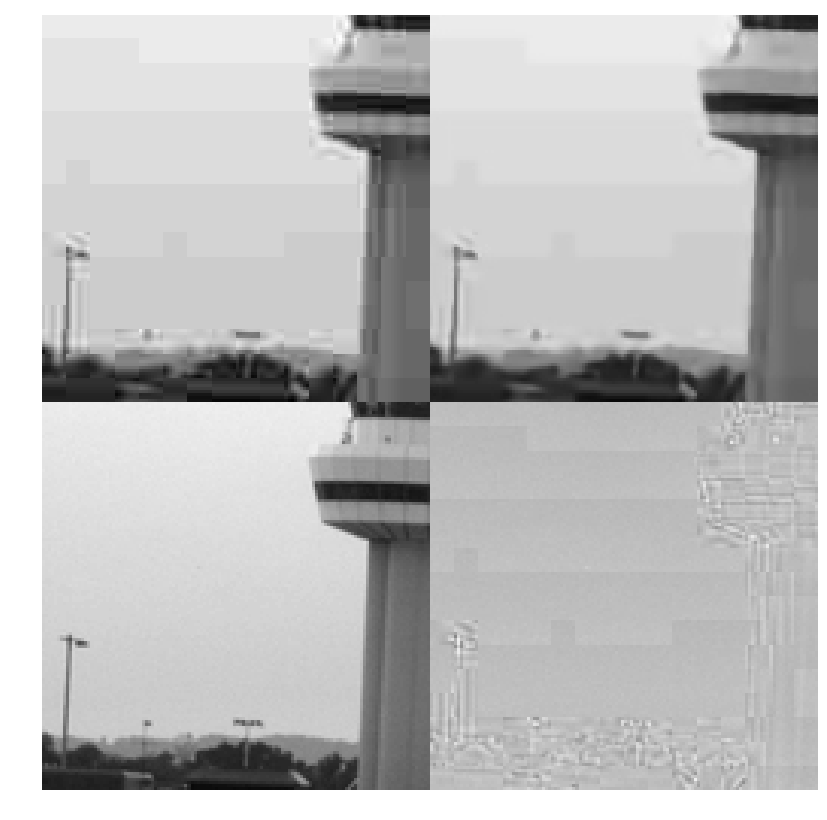

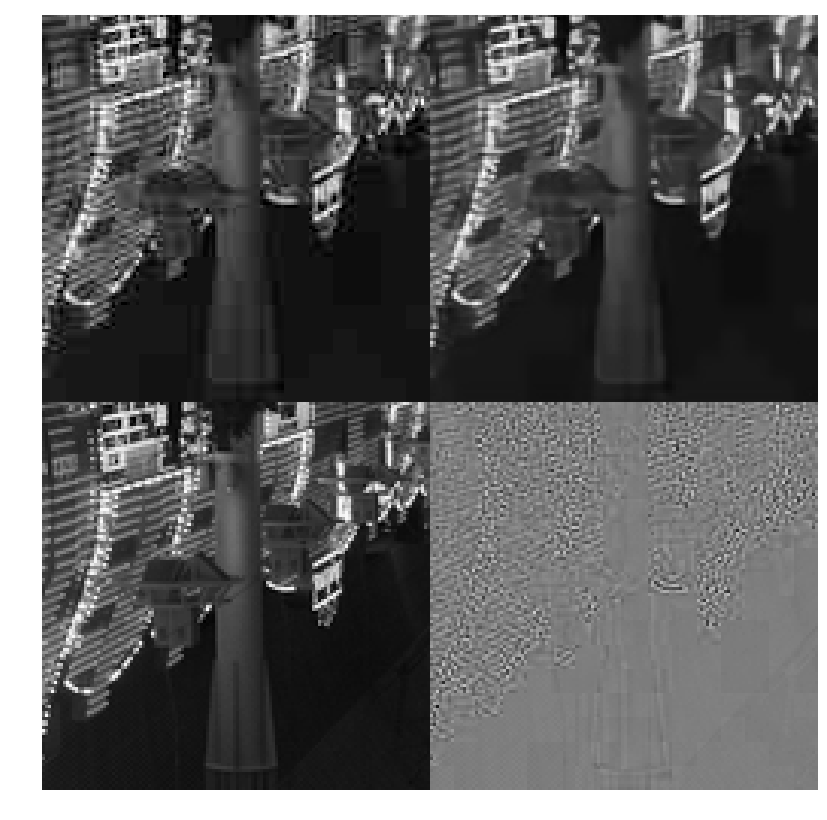

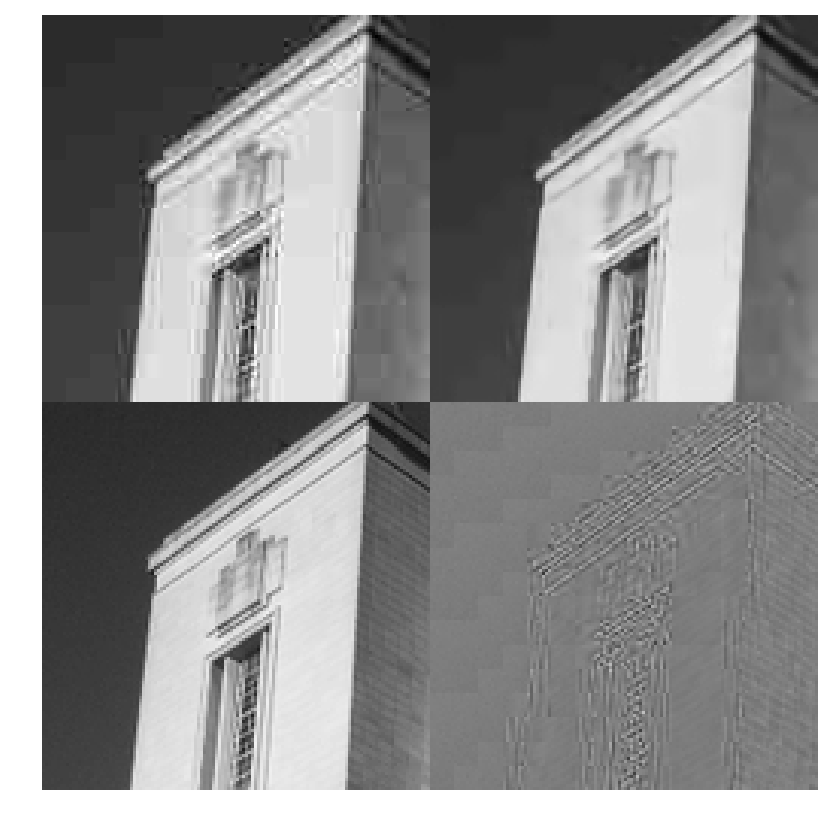

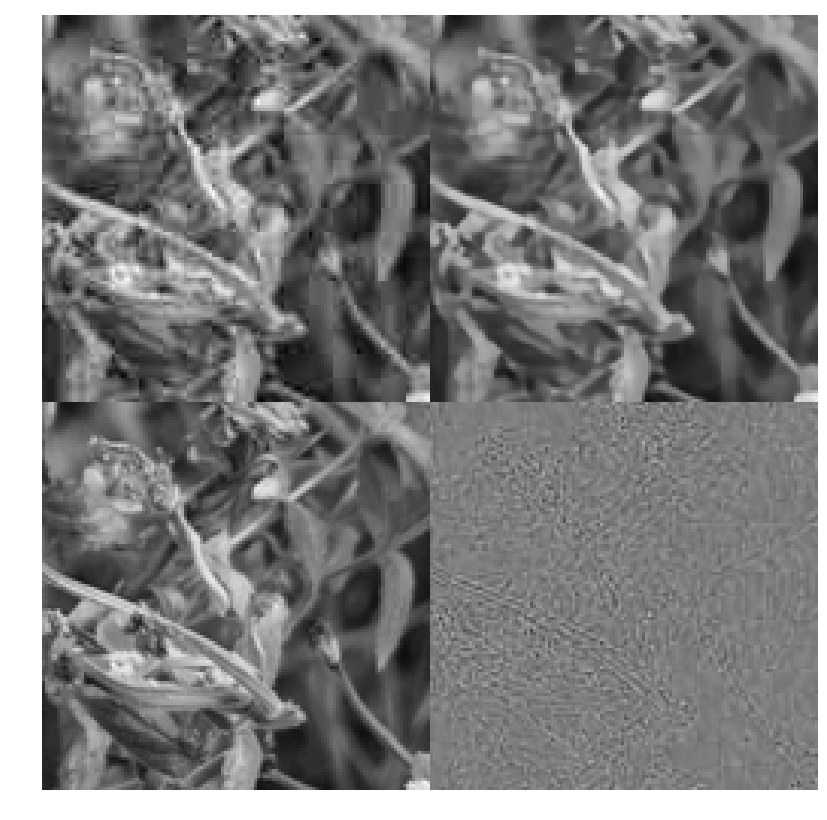

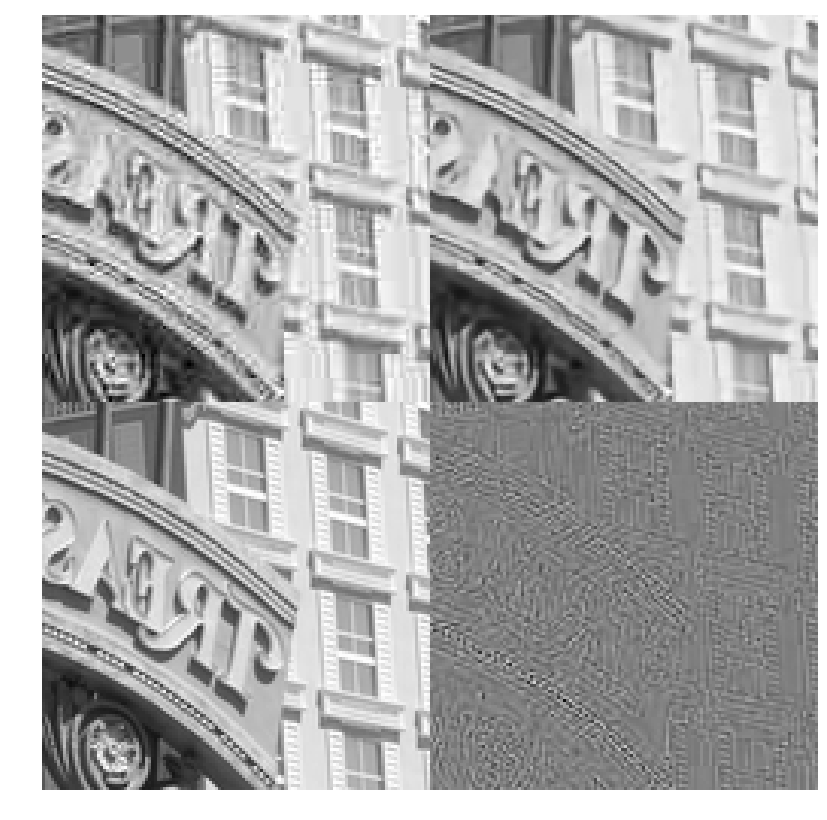

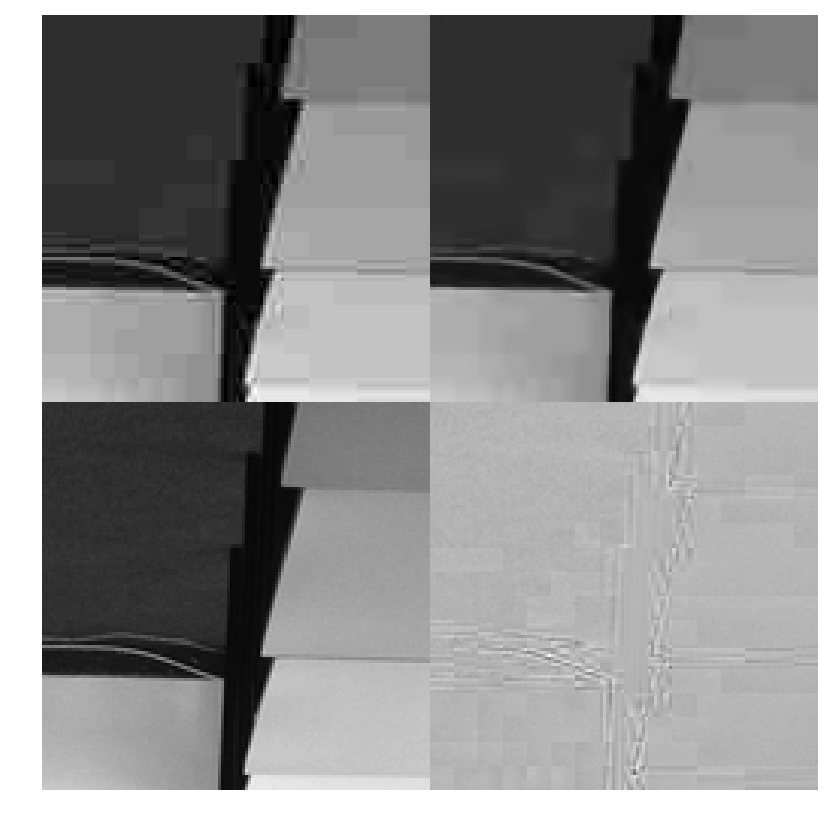

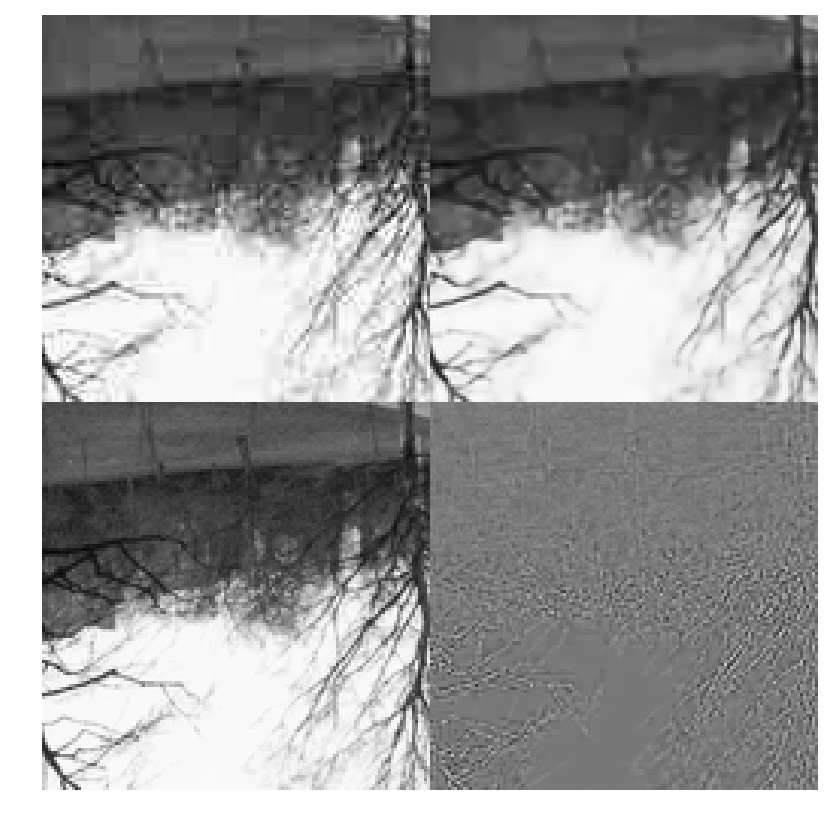

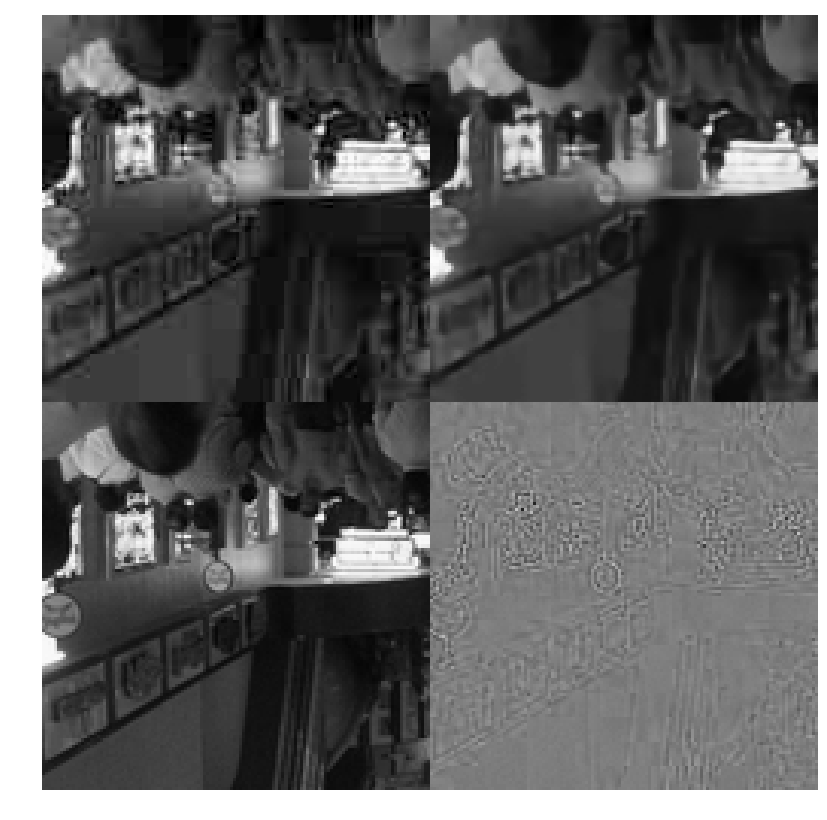

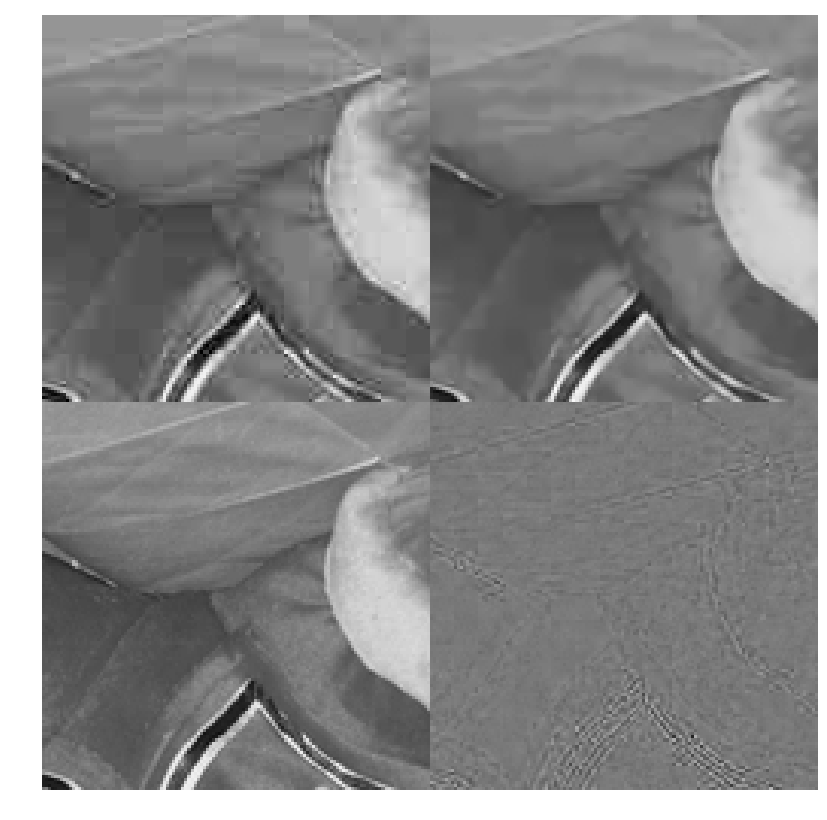

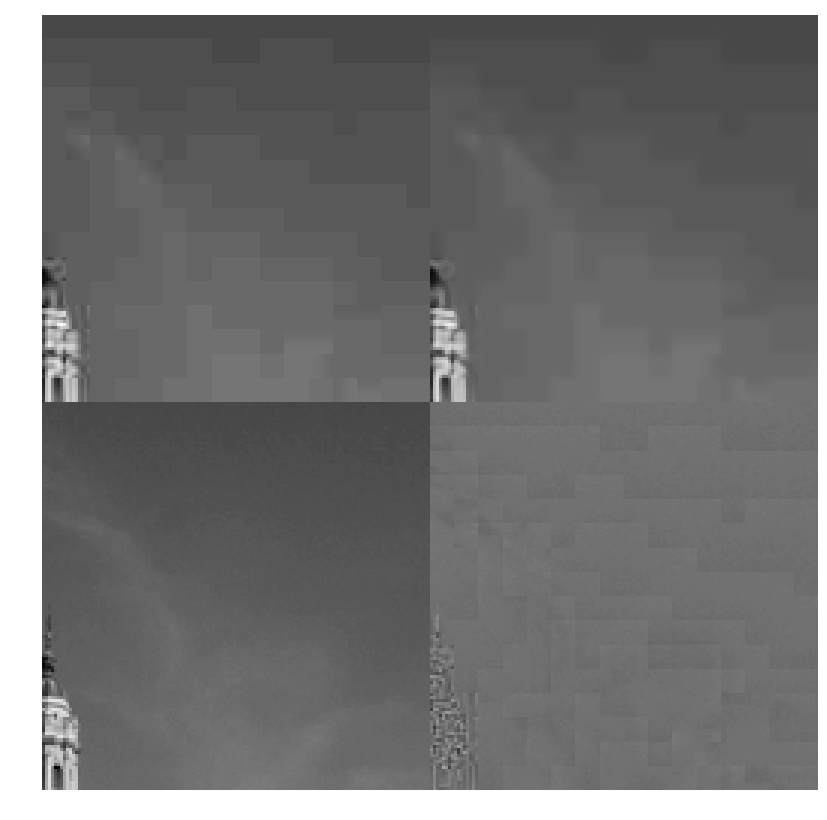

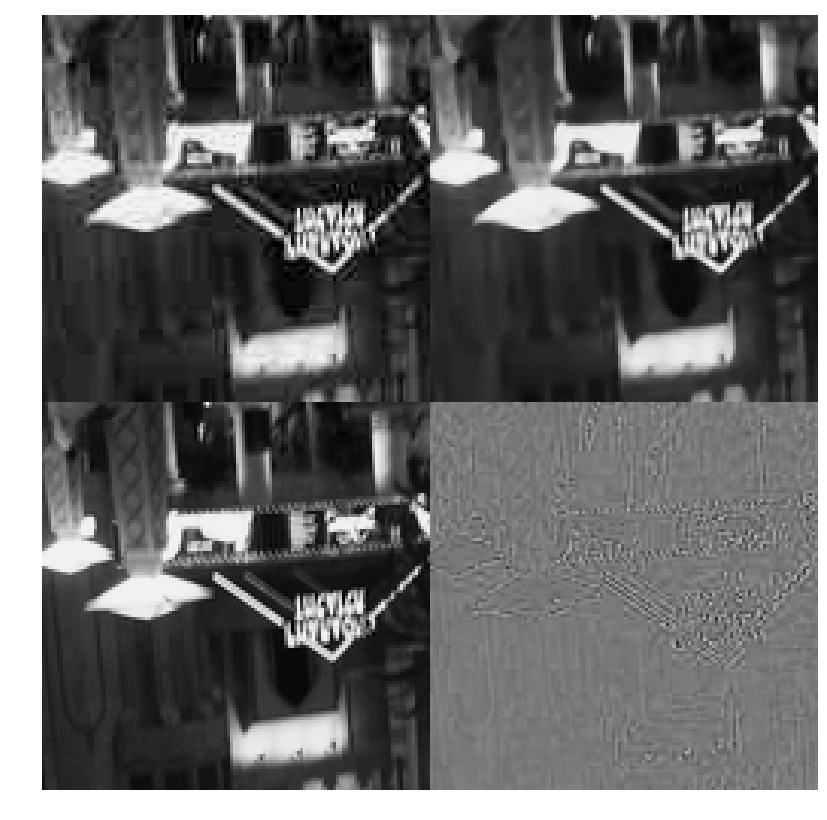

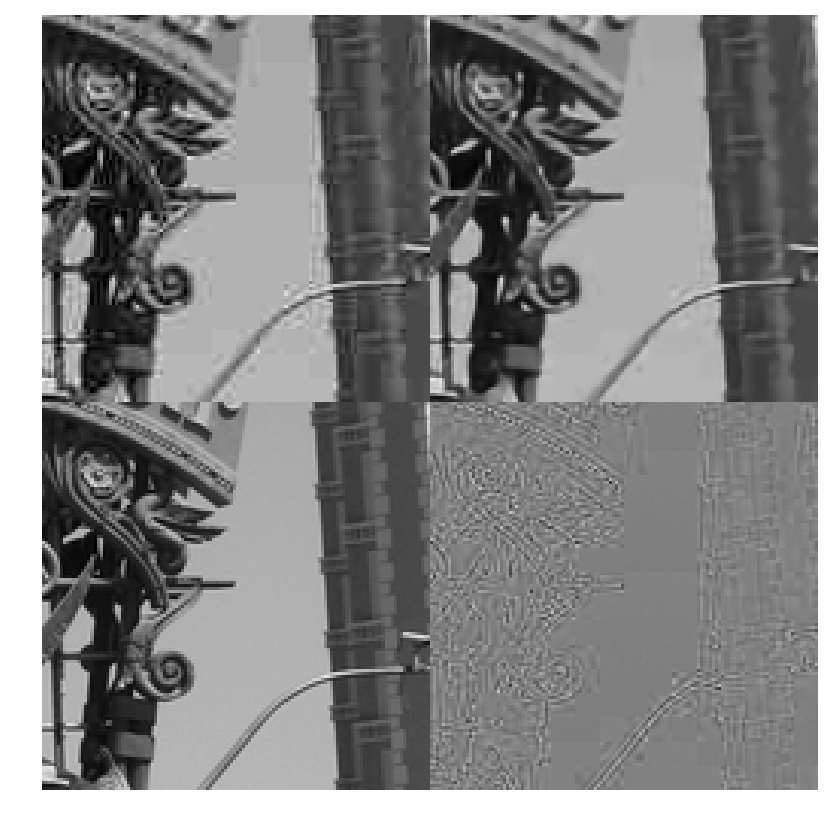

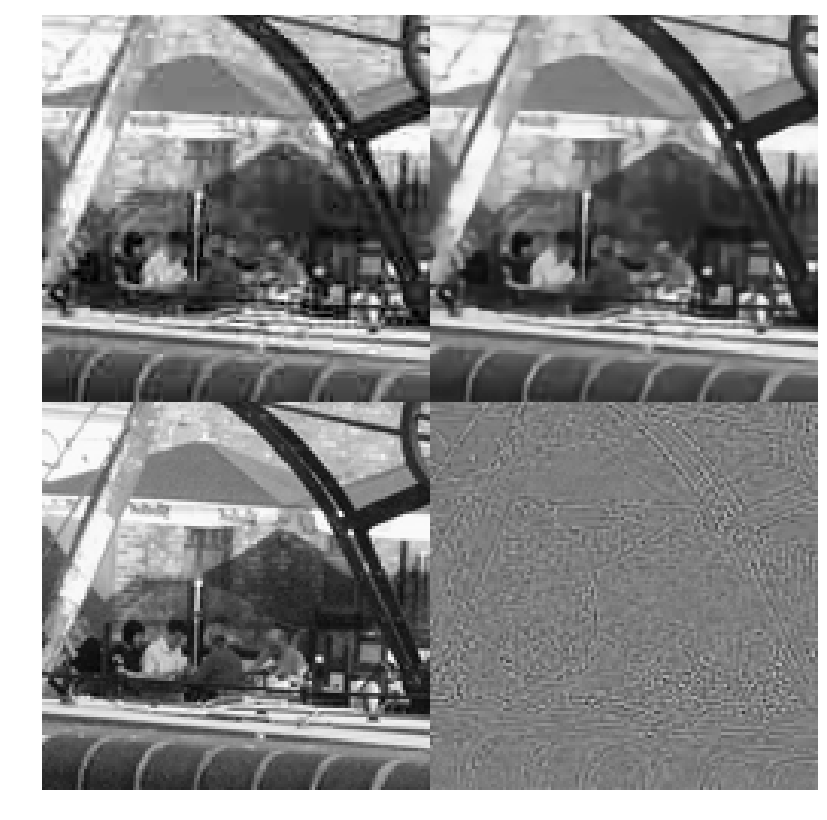

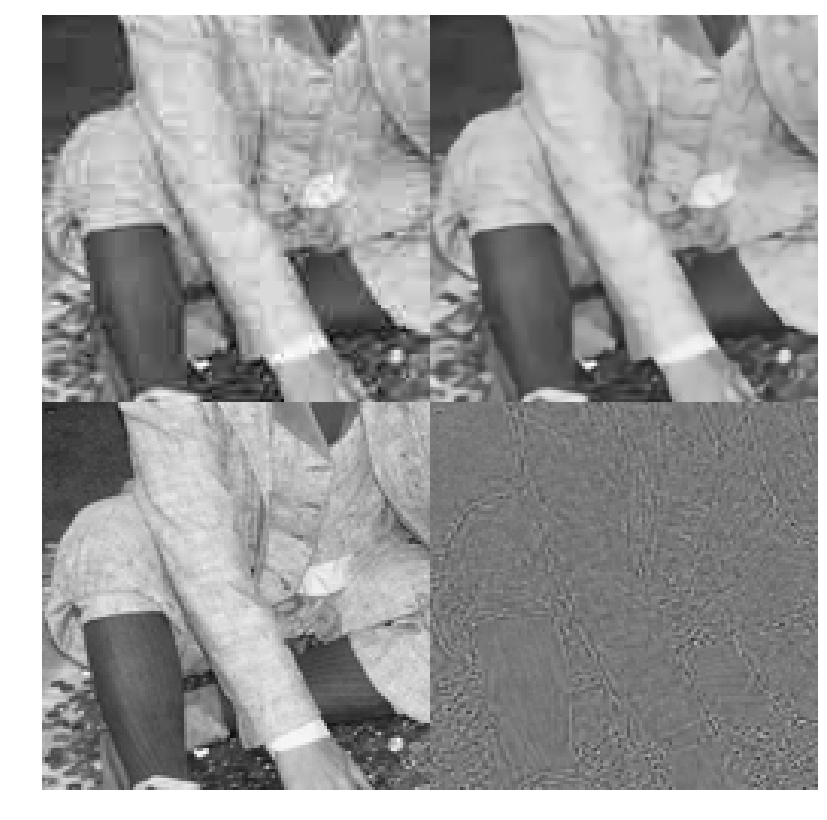

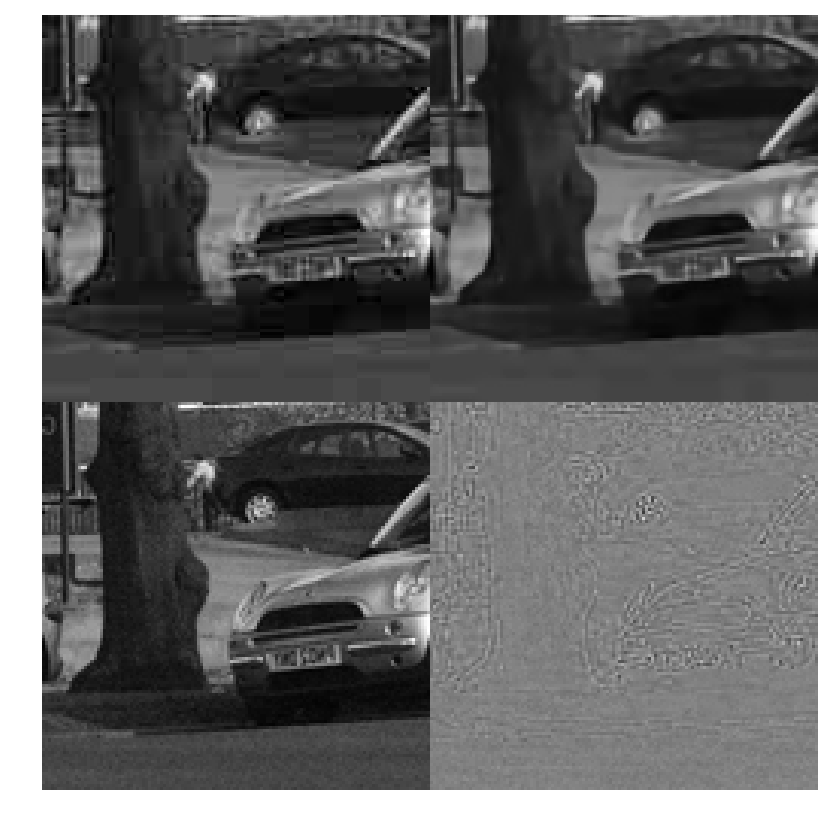

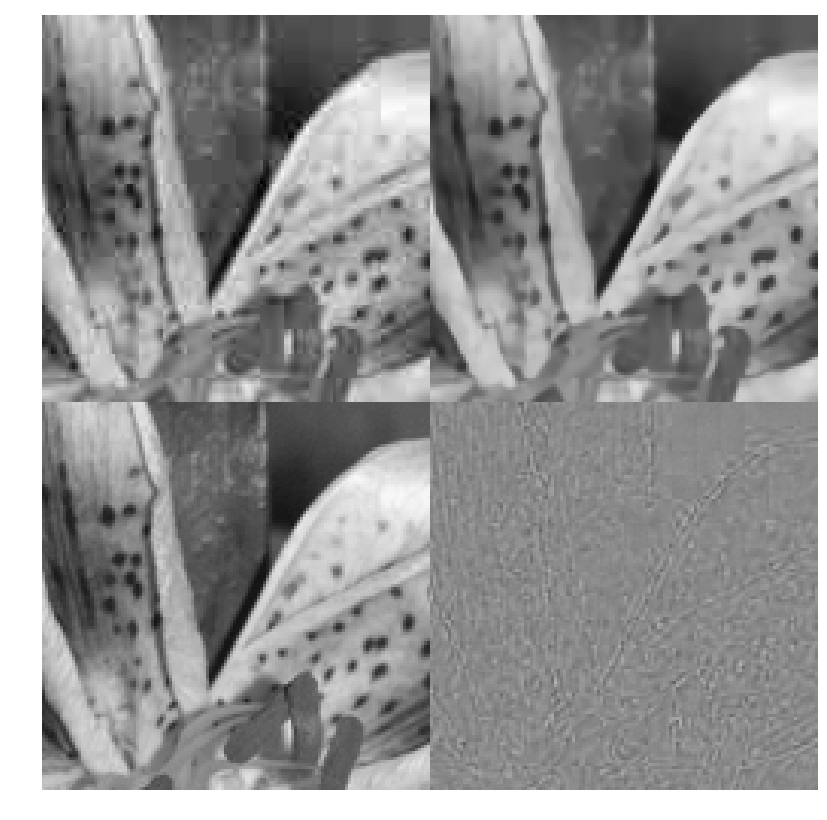

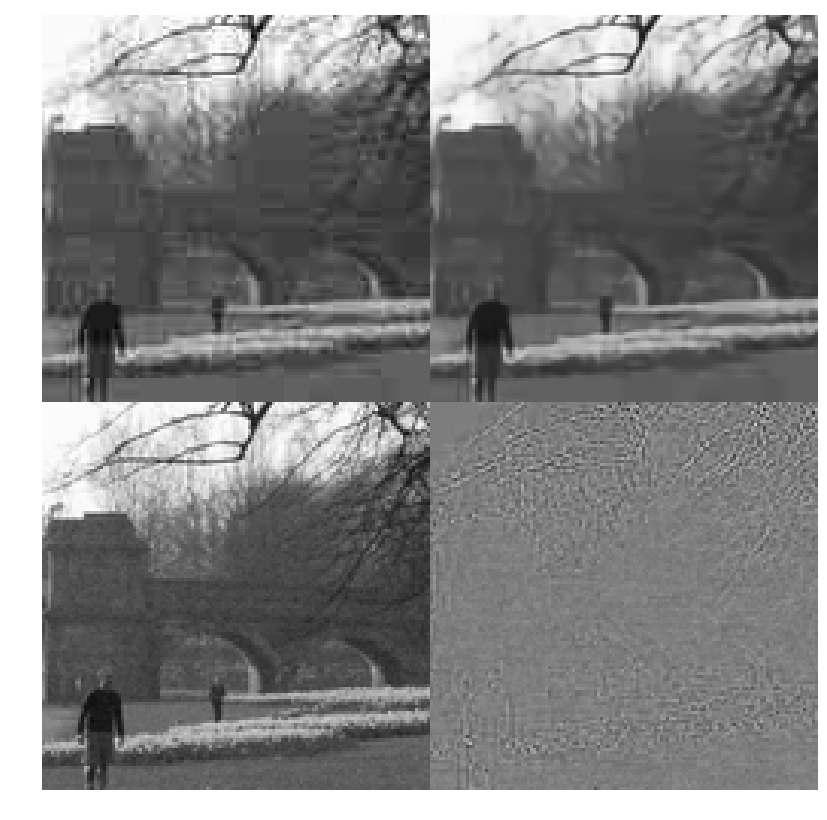

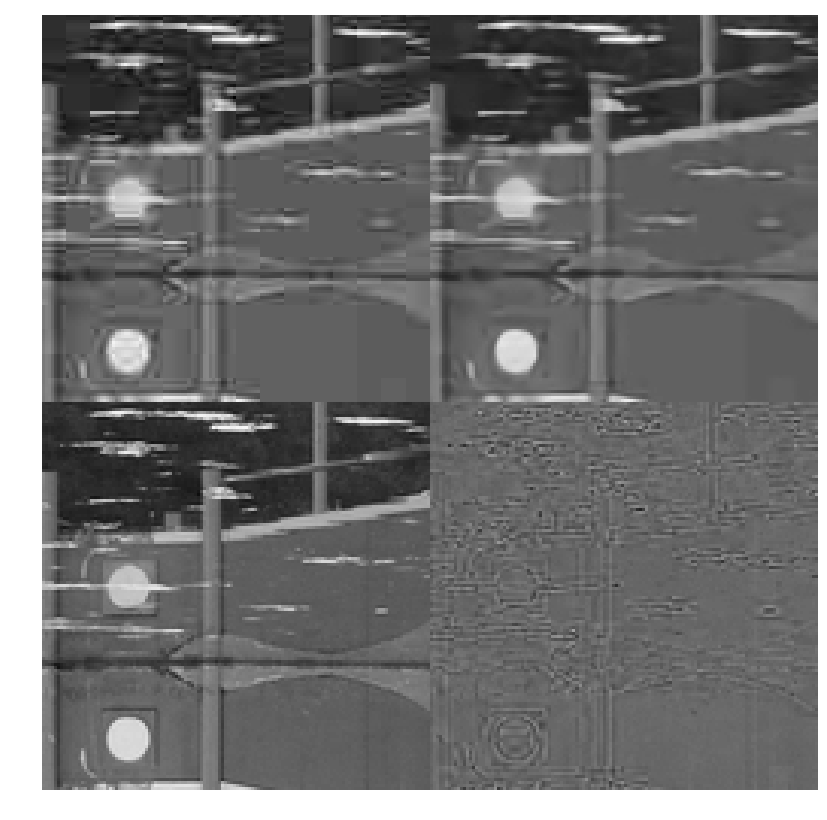

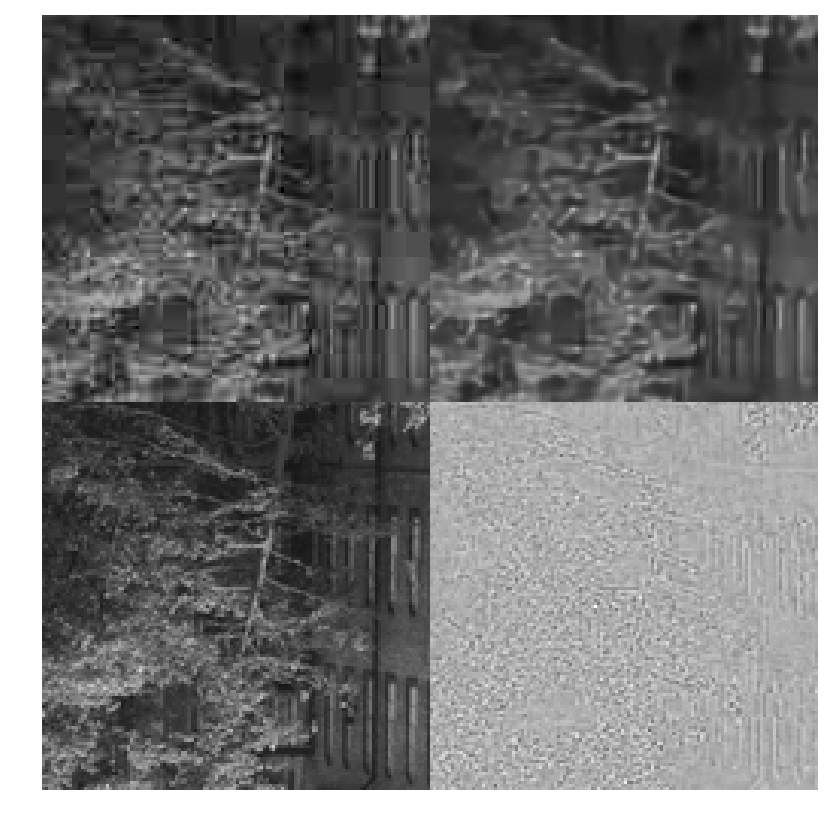

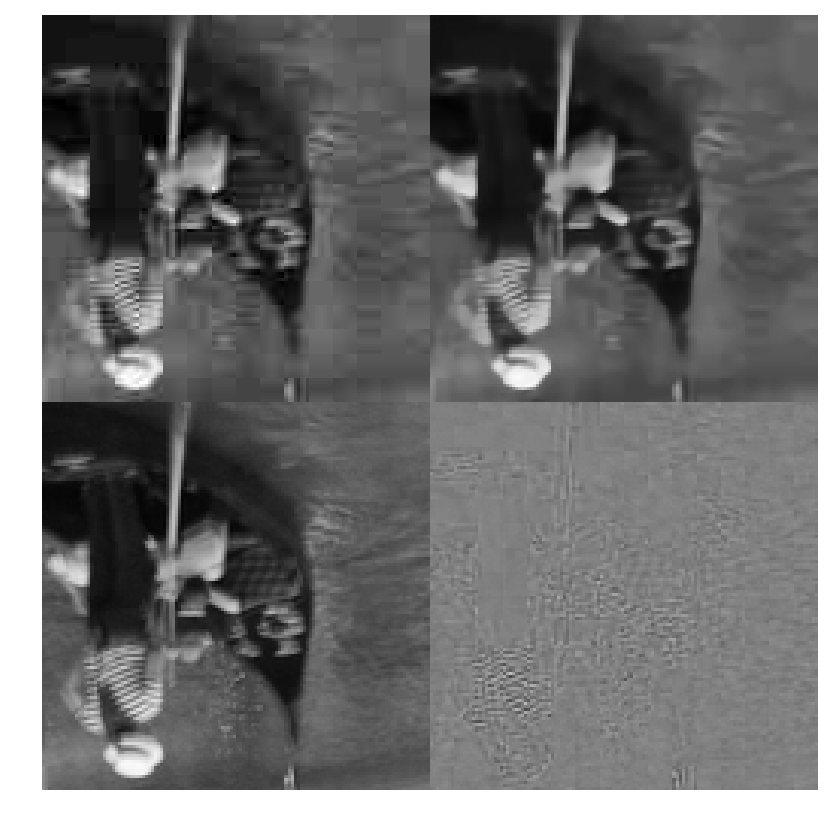

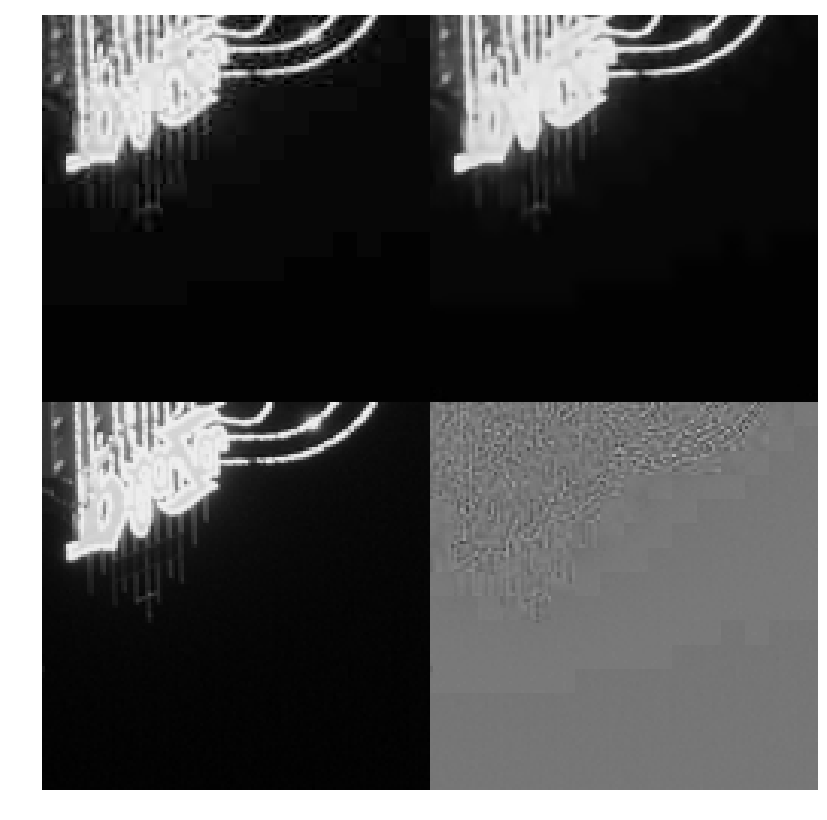

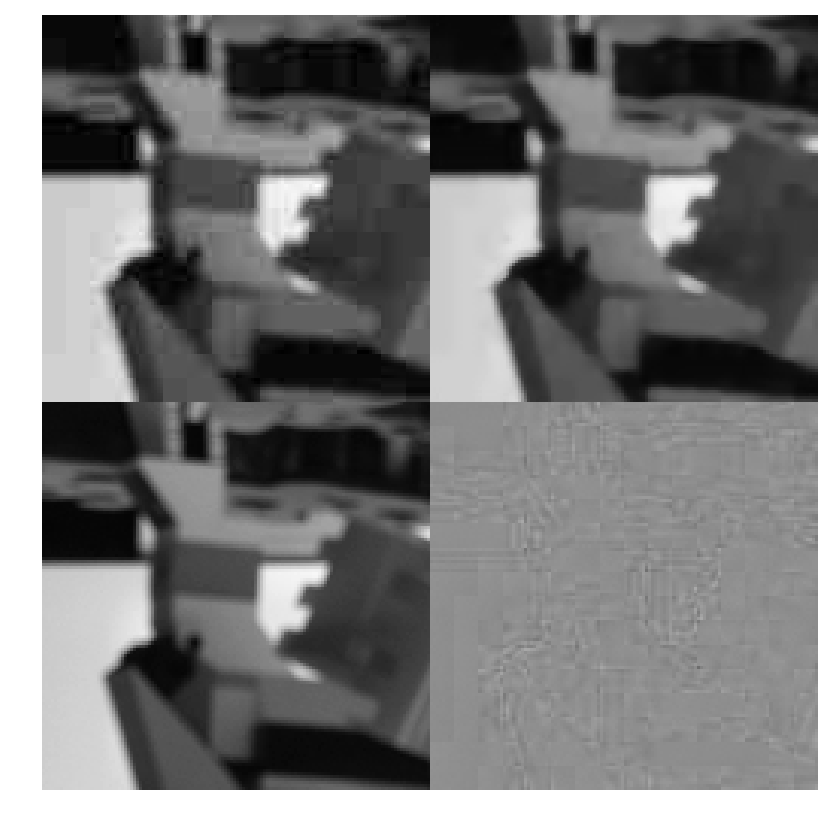

In [20]:
residual = False


import matplotlib.pyplot as plt
for pred, target, orig in zip(y_pred, y_target, x_images):
    
    #print np.mean(orig), np.mean(pred), np.mean(target)
    #print np.min(orig), np.min(pred), np.min(target)
    
    #print np.abs(target-orig).sum(), np.abs(target-pred).sum(), np.abs(target-pred).sum()-np.abs(target-orig).sum()
    
    plt.figure(figsize=(10,10))
    plt.axis('off')
    if residual:
        plot_img = np.vstack((  np.hstack((orig[0],pred[0]+orig[0])), np.hstack((orig[0]+target[0],pred[0])) ))*255
    else:
        plot_img = np.vstack((  np.hstack((orig[0],pred[0])), np.hstack((target[0],orig[0]-target[0])) ))*255
    
    plt.imshow(plot_img, interpolation='nearest', cmap='gray')
    plt.show()
    

''